# **Семинар №5**. Real data = real pain

## **5.1 Пайплайн работы с Dataset-ом**

### **5.1.1 Загружаем в colab**

In [76]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


import torchvision
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import PIL
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.is_available()

True

In [3]:
#прикручиваем свой гуглдиск, куда закинули архивы с данными
#from google.colab import drive

#drive.mount("/content/gdrive", force_remount=True)

In [4]:
#указываем путь к данным
data_path = "./data/"
train_ann_path = data_path + 'train.csv'

#читаем аннотацию
train_df = pd.read_csv(train_ann_path)
print(train_df.head())

     filename  class_number
0  000000.png            18
1  000001.png            18
2  000002.png            18
3  000003.png            18
4  000004.png             9


In [5]:
#команды для bash пишутся с !
#!ls '/content/gdrive/My Drive/Colab Notebooks/OM 2021/05. Real data/signs/'

In [6]:
# разархивируем, -q - не выводить логи
#!unzip -q '/content/gdrive/My Drive/Colab Notebooks/OM 2021/05. Real data/signs/train.zip' -d './'

In [7]:
# разархивируем
#!unzip -q '/content/gdrive/My Drive/Colab Notebooks/OM 2021/05. Real data/signs/test.zip' -d './'

In [8]:
print(len(os.listdir('./data/train/')))
print(len(os.listdir('./data/test/')))

25432
7551


Загрузили, можно дальше юзать как обычные папки с картинками.

### **5.1.2 Оборачиваем в Dataset**

Хорошо бы изучить раздел [`torch.utils.data`](https://pytorch.org/docs/stable/data.html).

**Refresh**: `Dataloader` должен получить `Dataset`, по которому он будет итерироваться и собирать данные в батчи заданного размера. Датасеты могут быть разные, главное - у него должен быть либо метод `__getitem__()` - который отдает информацию по 1 объекту датасета (само изображение, метка класса, путь, что угодно ещё), либо метод `__iter__()` - который возвращает итератор по объектам датасета.

Мы, как и раньше, будем использовать первый вариант - создадим наследника класса [`data.Dataset`](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset) и перегрузим методы `__getitem__()`, который по индексу должен возвращать элемент датасета, а также `__len__()`, который возвращает длину датасета.

In [9]:
class OurDataset(data.Dataset): #отпочковались
  """Our dataset class.

    Arguments:
        root (str): path to images
        imlist - pandas DataFrame with columns file_name, class
        transform - torchvision transform applied to every image
    """
  def __init__(self, root, flist, transform=None):
        self.root   = root
        self.imlist = flist #в нашем случае это будет датафрейм
        self.transform = transform

  def __getitem__(self, index):
        #берем строку из пришедшего df по index
        impath, target = self.imlist.loc[index]

        #собираем полное имя картинки
        full_imname = os.path.join(self.root, impath)

        if not os.path.exists(full_imname): #если нет такой, ругаемся
            print('No file ', full_imname)
            pass

        #Сразу используем PIL тк torchvision.transforms работает с PIL Image (https://pytorch.org/docs/stable/torchvision/transforms.html)
        img = Image.open(full_imname).convert('RGB')

        #применяем к изображению выбранное преобразование (аугментацию)
        img = self.transform(img)

        #на выход отдаём img, target - нужны для обучения и валидации
        return img, target, impath

  #метод возвращает длину датасета - просто как длину подаваемого dataframe
  def __len__(self):
        return len(self.imlist)

In [10]:
#готовим всё для подачи в OurDataset и заведение DataLoader

#преобразование для train и val пока одинаковое
transform_for_train_and_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
        ])

#датафреймы
train, val = train_test_split(train_df, test_size=0.15, random_state=24)

#нам нужно будет обращаться по индексу, так что делаем reset
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

batch_size=32

In [11]:
trainset = OurDataset(root='./data/train', flist=train, transform=transform_for_train_and_val)
valset = OurDataset(root='./data/train', flist=val, transform=transform_for_train_and_val)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, pin_memory=True)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=8, shuffle=True, pin_memory=True)
#valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, num_workers=8, pin_memory=True)

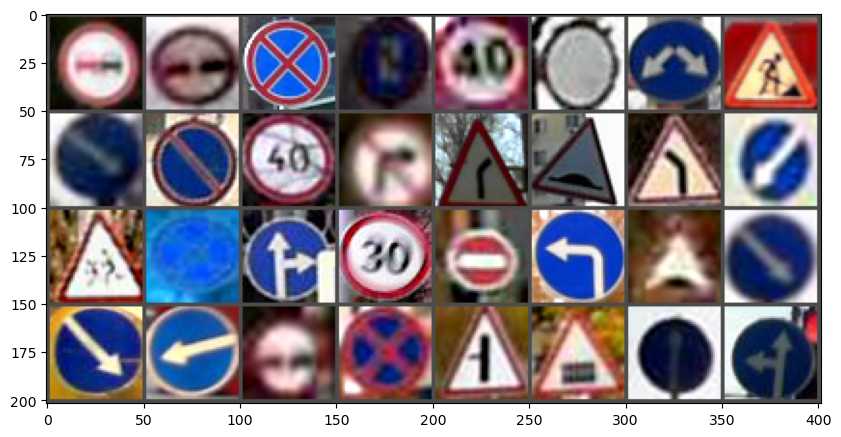

In [12]:
def myshow(img):
    img = img * 0.3 + 0.3 #умножаем на std, прибавляем mean - в Normalize всё наоборот
    npimg = img.detach().numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(npimg.transpose(1, 2, 0))

trainiter = iter(trainloader)
images, labels, impaths = next(trainiter)
myshow(torchvision.utils.make_grid(images))

In [13]:
print(images.shape)
print(labels)
print(impaths)

torch.Size([32, 3, 48, 48])
tensor([38, 38, 48, 51, 42, 37, 65, 19, 63, 49, 42, 34,  1,  9,  1, 64, 18, 48,
        60, 41, 29, 59,  9, 63, 63, 64, 38, 48, 26,  0, 55, 61])
['011501.png', '008228.png', '002045.png', '025319.png', '001489.png', '016407.png', '014548.png', '009447.png', '000294.png', '016553.png', '013611.png', '004941.png', '018279.png', '019596.png', '000805.png', '001707.png', '019818.png', '000166.png', '023942.png', '021586.png', '018839.png', '007459.png', '016349.png', '003831.png', '007281.png', '009452.png', '012986.png', '012599.png', '006555.png', '012293.png', '002369.png', '001559.png']


С данными справились, ну какие молодцы.

## **5.2. Посмотрим на архитектуры**

Давайте ещё немного посмотрим на доступные модели в [`torchvision.models`](https://pytorch.org/vision/stable/models.html) и полазаем в документации.

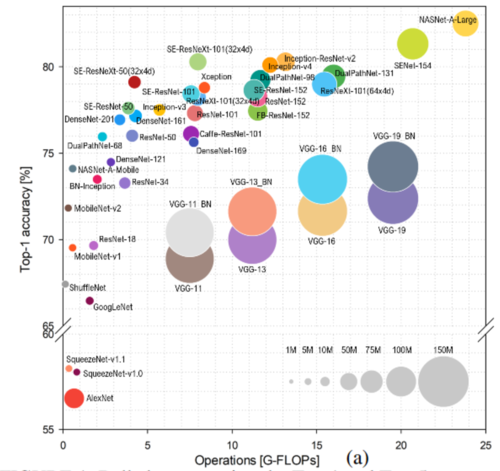

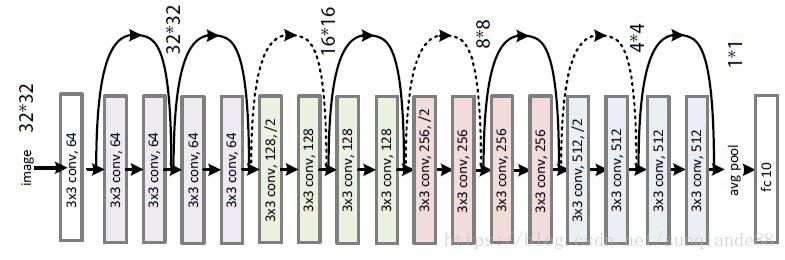

In [14]:
resnet18 = models.resnet18(pretrained=True)

In [15]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **5.3 Как учить круче**

Вспомним сновь основные составляющие эксперимента по DL:

 - `net` (тут миллион вариантов архитектур)
 - `data` (их можно аугментировать)
 - `initialization` (`pretrained` веса/инициализация из распределения)
 - `loss`  (обычно `CE`)
 - `optimizer` (тут обычно пара вариантов - `SGD/Adam`)
 - `hyperparams`: число эпох, размер батча
 - `lr` и стратегия его изменения

Обзор трюков для улучшения работы сверточных сеток для классификации можно найти [тут](https://arxiv.org/pdf/1812.01187v2.pdf) и в лекциях 2-3 (часть из них мы сегодня рассмотрим).


###**5.3.1 Получим baseline**

In [16]:
## берем легкую сеть,
class EasyCNN(nn.Module):
    def __init__(self, n_classes):
        super(EasyCNN, self).__init__()

        self.conv_block = nn.Sequential(
          nn.Conv2d(3, 24, 3),
          nn.LeakyReLU(),
          nn.Conv2d(24, 12, 3),
          nn.LeakyReLU()
        )

        self.fc_layers = nn.Sequential(
          nn.Linear(12*44*44, n_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view((x.shape[0], -1)) #flatten
        x = self.fc_layers(x)

        return x

In [17]:
#сеть завели, на GPU положили
net = EasyCNN(n_classes=67)
net = net.cuda()

#гиперпараметры завели
lr = 3e-4 #choose
num_epochs = 5 #choose no more than 10

#loss функцию, оптимайзер выбрали
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr) #choose

Вообще говоря, `train/val` процессы не особо отличаются. Зачем же для них писать отдельные функции `train/evaluate`? Ни зачем, но на первый порах линейный код воспринимать было легче.

Давайте теперь напишем одну функцию: `run_epoch` у которой будет параметр `is_train: True` для обучения, `False` - для `evaluation`.

In [18]:
def run_epoch(epoch, is_train):
  """
  Training and evaluaton loop over samples
  Args:
      train_mode (bool): True for train mode
  """
  if is_train:
      net.train()
      loader = trainloader
      print("Training epoch: ", epoch + 1, "/", num_epochs)
  else:
      net.eval()
      loader = valloader
      print('Validation')

  running_loss = 0.0
  correct = 0.0
  total = 0.0

  for i, data in enumerate(loader):
      # берем батч, кладем на GPU
      images, labels, _= data
      images, labels = images.cuda(), labels.cuda()

      #мы всегда прогоняем батч через сеть и считаем loss
      outputs = net(images)
      loss = criterion(outputs, labels)

      #занулять градиенты, считать новые, обновлять веса - всё нужно только на обучении
      if is_train:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      #пополняем логи
      running_loss += loss.item()
      total += images.data.size(0)

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels.data).sum()

  #после эпохи или валидации логируем
  print('Loss: {:.3f}, accuracy: {:.3f}'.format(running_loss / (i + 1), correct / total * 100.0))

In [19]:
%%time
#а теперь просто запускаем функцию с разными значениями is_train для каждой эпохи
for epoch in range(num_epochs):
  #training
  run_epoch(epoch, is_train=True)

  #validation
  with torch.no_grad():
      run_epoch(epoch, is_train=False)

  print('----------------------')

print('Finished training! Enjoy your results!')

Training epoch:  1 / 5
Loss: 0.777, accuracy: 80.885
Validation
Loss: 0.387, accuracy: 90.170
----------------------
Training epoch:  2 / 5
Loss: 0.260, accuracy: 93.209
Validation
Loss: 0.329, accuracy: 91.691
----------------------
Training epoch:  3 / 5
Loss: 0.151, accuracy: 95.744
Validation
Loss: 0.300, accuracy: 92.765
----------------------
Training epoch:  4 / 5
Loss: 0.090, accuracy: 97.419
Validation
Loss: 0.314, accuracy: 92.503
----------------------
Training epoch:  5 / 5
Loss: 0.058, accuracy: 98.390
Validation
Loss: 0.317, accuracy: 93.263
----------------------
Finished training! Enjoy your results!
CPU times: total: 4min 42s
Wall time: 1min 28s


### **5.3.2 Augment it all**

Вообще говоря, обычно преобразования на обучении и тесте не совпадают. Что важно сохранять единым: подаваемый размер картинок, нормализацию.

В аугментации на обучении можно накрутить много всего, даже используя только [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html). Иллюстрации [тут](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py).


In [20]:
transform_for_train = transforms.Compose(
    [
        transforms.ColorJitter(brightness=(0.3, 1.0), contrast=(0.8, 1.2)),
        transforms.RandomRotation((-15, 15)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


transform_for_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [21]:
trainset = OurDataset(root='./data/train', flist=train, transform=transform_for_train)
valset = OurDataset(root='./data/train', flist=val, transform=transform_for_val)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, pin_memory=True)

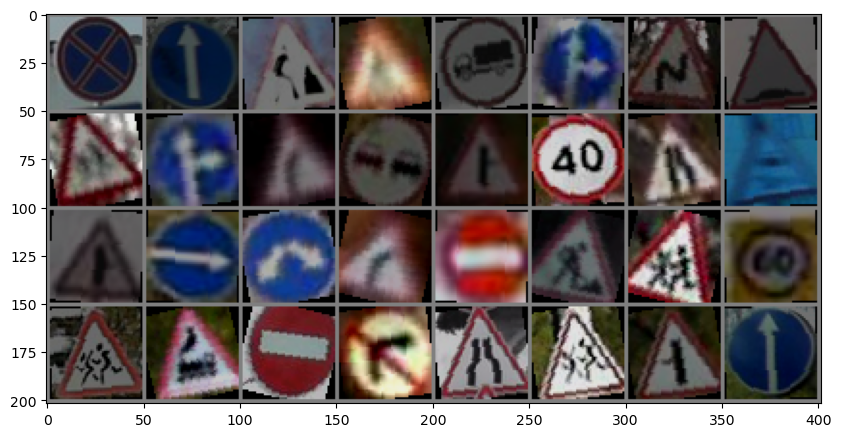

In [22]:
def myshow(img):
    img = img * 0.5 + 0.5 #умножаем на std, прибавляем mean - в Normalize всё наоборот
    npimg = img.detach().numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(npimg.transpose(1, 2, 0))

trainiter = iter(trainloader)
images, labels, impaths = next(trainiter)
myshow(torchvision.utils.make_grid(images))

In [23]:
net = EasyCNN(n_classes=67)
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr)

In [24]:
%%time
for epoch in range(num_epochs):
  #training
  run_epoch(epoch, is_train=True)

  #validation
  with torch.no_grad():
      run_epoch(epoch, is_train=False)

  print('----------------------')

print('Finished training! Enjoy your results!')

Training epoch:  1 / 5
Loss: 1.240, accuracy: 69.871
Validation
Loss: 0.516, accuracy: 86.632
----------------------
Training epoch:  2 / 5
Loss: 0.530, accuracy: 86.020
Validation
Loss: 0.401, accuracy: 90.328
----------------------
Training epoch:  3 / 5
Loss: 0.383, accuracy: 89.878
Validation
Loss: 0.346, accuracy: 91.638
----------------------
Training epoch:  4 / 5
Loss: 0.312, accuracy: 91.460
Validation
Loss: 0.328, accuracy: 92.477
----------------------
Training epoch:  5 / 5
Loss: 0.257, accuracy: 93.056
Validation
Loss: 0.287, accuracy: 93.290
----------------------
Finished training! Enjoy your results!
CPU times: total: 6min 5s
Wall time: 1min 56s


При добавлении сложных рандомизированных аугментаций есть смысл увеличивать число эпох (так ваша сетка увидит больше, в том числе увидит непреобразованные изначальные картинки).

На валидации сейчас мы видим результат хуже, чем раньше. Это ожидаемо - данных стало больше, они теперь меньше похожи на данные из `valset`. Это не обязательно значит, что он будет на тесте хуже! Надо смотреть, как отличаются домены данных на валидации и тесте.

В `torchvision.transforms` мы имеем совсем базовый набор аугментаций. Если в ваших целевых данных на объектах есть, снег/грязь/засветы/теплый свет/сложные структуры/туман, данных аугментаций вам не хватит.

Есть крутые библиотеки, созданные спецаильно чтобы решить такие проблемы: [`imgaug`](https://github.com/aleju/imgaug), [`albumentations`](https://github.com/albumentations-team/albumentations). Но есть нюанс - они юзают внутри себя `opencv`, а значит нещадно размножаются и едят `CPU`, это может приводить к проблемам.

Аугментации из них можно вставить в ваш `transform` используя `transforms.Lambda`.

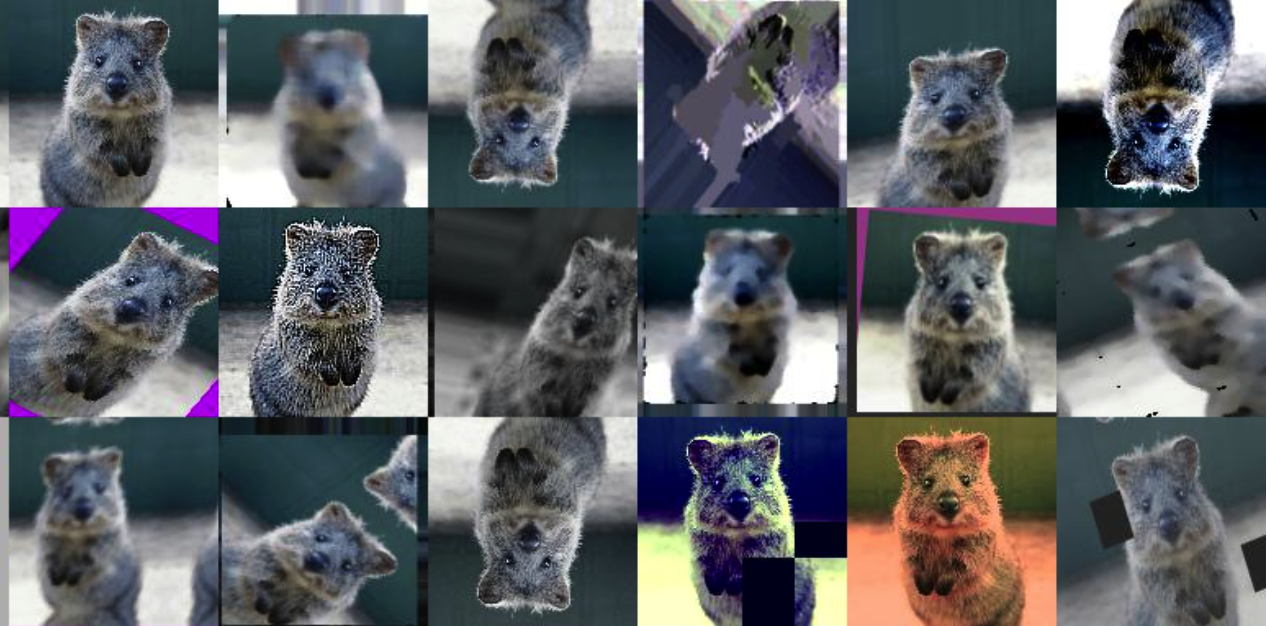

Есть и более хитрые аугментации, усложняющие жизнь сети и работающие часто как регуляризация: `Mixup`, `Cutout`, [`Cutmix`](https://arxiv.org/pdf/1905.04899.pdf), `GridMask`. К статье про `Cutmix` приложен код, можно посмотреть как они это [реализовывали](https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py#L228), в целом ничего страшного, реализации [GridMask](https://github.com/dvlab-research/GridMask) тоже можно найти.

Такие витиеватые вещи могут помочь, когда надо добить последние проценты до нужного качества и поможет сгладить проблему переобучения.

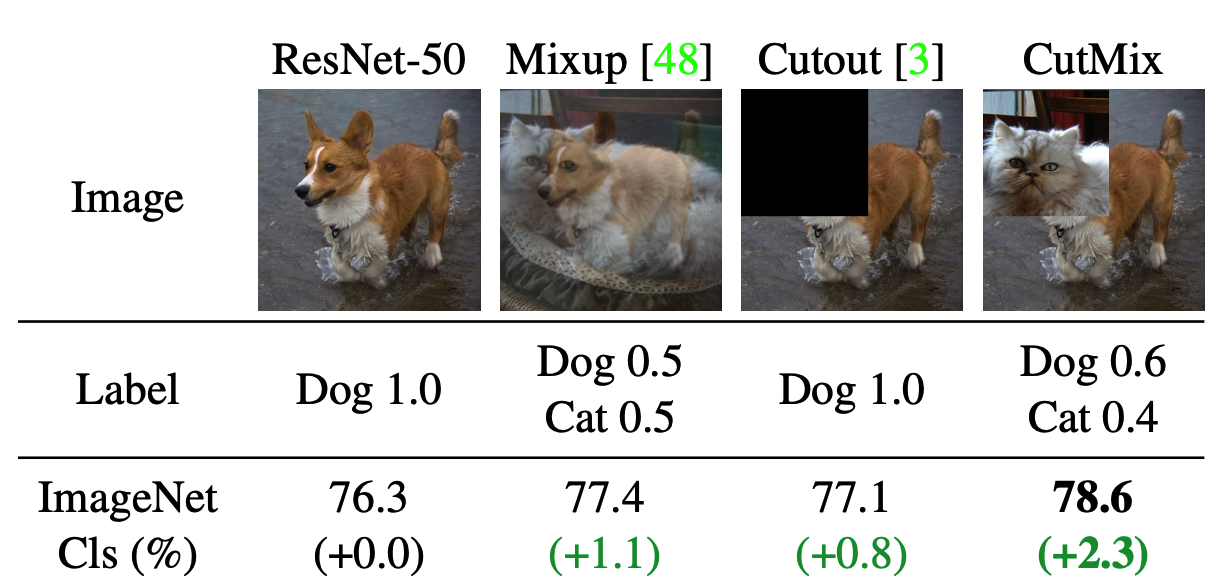

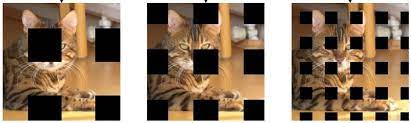

### **5.3.3 Такой маленький, но важный learning rate**

Важность `lr` и его изменения сложно переоценить. Благодаря грамотному изменению `lr` можно наиболее эффективно провести оптимизацию.

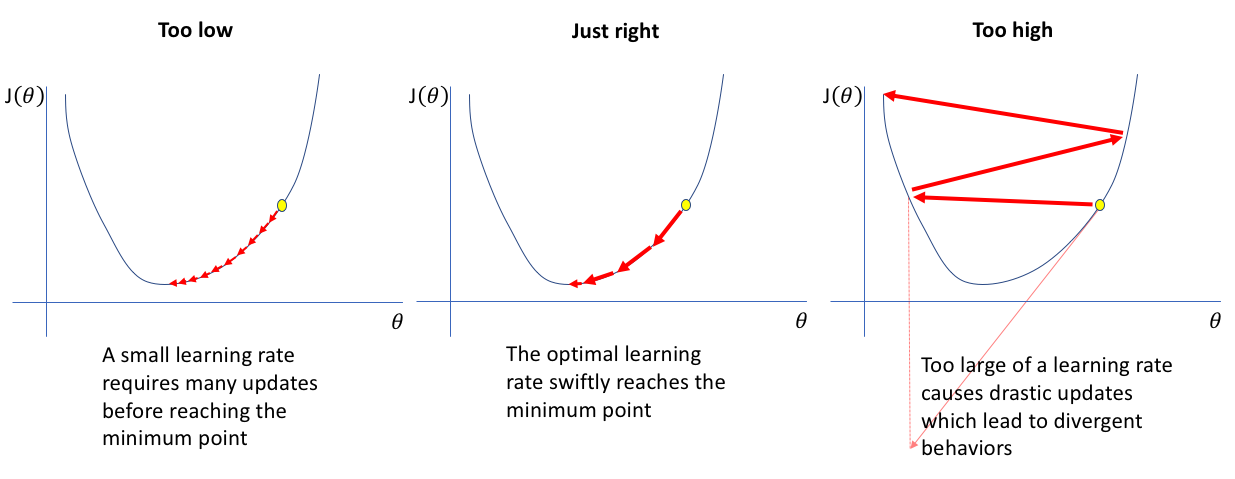

Какие бывают стратегии?

- Пока точность растет, не трогаем, если не растет `N` эпох, умееньшаем в `m` раз
- Уменьшаем в `m` раз каждые `N` эпох
- Менять после каждого батча по cosine закону
- Каждую эпоху умножать на `alpha`
- Менять после каждого батча по `cosine` закону, а когда дошли до 0, сделать `warmup` до `lr initial`
- При обучени с нуля больших сетей с небольшим `lr` дойти до какой то небольшой точности, а затем сделать warmup до большого значения и идти по `cosine` с него

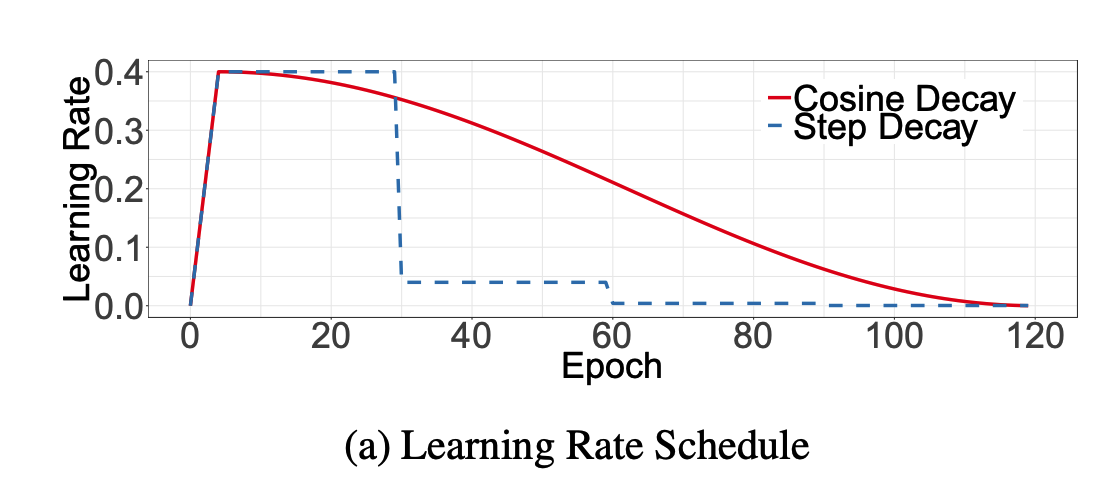

В `pytorch` есть такая вещь как `Scheduler`, который при своем шаге меняет `lr` у `optimizer`

Смотри раздел [`How to adjust learning rate`](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [25]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [33]:
transform_for_train_and_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])])


trainset = OurDataset(root='./data/train', flist=train, transform=transform_for_train_and_val)
valset = OurDataset(root='./data/train', flist=val, transform=transform_for_train_and_val)

batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, pin_memory=True)

#### [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR)

In [67]:
net = EasyCNN(n_classes=67)
net = net.cuda()

lr = 0.01
num_epochs = 5

optimizer = optim.Adam(net.parameters(), lr) #оптимайзер привязан к сети
scheduler = StepLR(optimizer, step_size=1, gamma=0.1) #scheduler привязан к оптимайзеру

In [68]:
#впишем StepLR в процесс обучения
def run_epoch(epoch, is_train):
  """
  Training and evaluaton loop over samples
  Args:
      train_mode (bool): True for train mode
  """
  if is_train:
      net.train()
      loader = trainloader
      print("Training epoch: ", epoch + 1, "/", num_epochs)
  else:
      net.eval()
      loader = valloader
      print('Validation')

  running_loss = 0.0
  correct = 0.0
  total = 0.0

  for i, data in enumerate(loader):
      images, labels, _= data
      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      loss = criterion(outputs, labels)

      if is_train:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      running_loss += loss.item()
      total += images.data.size(0)

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels.data).sum()

  lr = scheduler.optimizer.param_groups[0]['lr']
  print('Loss: {:.3f}, accuracy: {:.3f}, lr: {}'.format(running_loss / (i + 1), correct / total * 100.0, lr))

  #шаг на эпоху должен быть один, сделаем его после валидации
  if not is_train:
    scheduler.step()

In [69]:
%%time
for epoch in range(num_epochs):
  #training
  run_epoch(epoch, is_train=True)

  #validation
  with torch.no_grad():
      run_epoch(epoch, is_train=False)

  print('----------------------')

print('Finished training! Enjoy your results!')

Training epoch:  1 / 5
Loss: 1.629, accuracy: 65.869, lr: 0.01
Validation
Loss: 0.697, accuracy: 83.172, lr: 0.01
----------------------
Training epoch:  2 / 5
Loss: 0.381, accuracy: 90.285, lr: 0.001
Validation
Loss: 0.484, accuracy: 88.073, lr: 0.001
----------------------
Training epoch:  3 / 5
Loss: 0.283, accuracy: 92.964, lr: 0.0001
Validation
Loss: 0.479, accuracy: 88.440, lr: 0.0001
----------------------
Training epoch:  4 / 5
Loss: 0.271, accuracy: 93.288, lr: 1e-05
Validation
Loss: 0.479, accuracy: 88.519, lr: 1e-05
----------------------
Training epoch:  5 / 5
Loss: 0.269, accuracy: 93.315, lr: 1.0000000000000002e-06
Validation
Loss: 0.479, accuracy: 88.493, lr: 1.0000000000000002e-06
----------------------
Finished training! Enjoy your results!
CPU times: total: 5min 13s
Wall time: 1min 28s


 #### [CosineLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR)

In [70]:
net = EasyCNN(n_classes=67)
net = net.cuda()

lr = 0.01
num_epochs = 50

optimizer = optim.Adam(net.parameters(), lr)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=int(len(trainset)/batch_size + 1)*num_epochs)

In [71]:
#впишем CosineLR в процесс обучения
def run_epoch(epoch, is_train):
  """
  Training and evaluaton loop over samples
  Args:
      train_mode (bool): True for train mode
  """
  if is_train:
      net.train()
      loader = trainloader
      print("Training epoch: ", epoch + 1, "/", num_epochs)
  else:
      net.eval()
      loader = valloader
      print('Validation')

  running_loss = 0.0
  correct = 0.0
  total = 0.0

  for i, data in enumerate(loader):
      images, labels, _= data
      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      loss = criterion(outputs, labels)

      if is_train:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          scheduler.step()

      running_loss += loss.item()
      total += images.data.size(0)

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels.data).sum()

  lr = scheduler.optimizer.param_groups[0]['lr']
  print('Loss: {:.3f}, accuracy: {:.3f}, lr: {}'.format(running_loss / (i + 1), correct / total * 100.0, lr))

In [72]:
%%time
for epoch in range(num_epochs):
  #training
  run_epoch(epoch, is_train=True)

  #validation
  with torch.no_grad():
      run_epoch(epoch, is_train=False)

  print('----------------------')

print('Finished training! Enjoy your results!')

Training epoch:  1 / 50
Loss: 1.850, accuracy: 65.203, lr: 0.009990133642141338
Validation
Loss: 0.717, accuracy: 83.145, lr: 0.009990133642141338
----------------------
Training epoch:  2 / 50
Loss: 0.502, accuracy: 87.228, lr: 0.009960573506572373
Validation
Loss: 0.446, accuracy: 88.938, lr: 0.009960573506572373
----------------------
Training epoch:  3 / 50
Loss: 0.346, accuracy: 91.044, lr: 0.009911436253643423
Validation
Loss: 5.228, accuracy: 66.186, lr: 0.009911436253643423
----------------------
Training epoch:  4 / 50
Loss: 67.482, accuracy: 62.775, lr: 0.009842915805643115
Validation
Loss: 5.451, accuracy: 73.971, lr: 0.009842915805643115
----------------------
Training epoch:  5 / 50
Loss: 2.201, accuracy: 83.643, lr: 0.009755282581475719
Validation
Loss: 2.285, accuracy: 83.172, lr: 0.009755282581475719
----------------------
Training epoch:  6 / 50
Loss: 1.038, accuracy: 87.343, lr: 0.009648882429441204
Validation
Loss: 1.765, accuracy: 83.827, lr: 0.009648882429441204
--

In [73]:
test_images = []
for filename in os.listdir('./data/test'):
    if filename[filename.rfind(".") + 1:] in ['jpg', 'jpeg', 'png']:
        test_images.append(filename)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


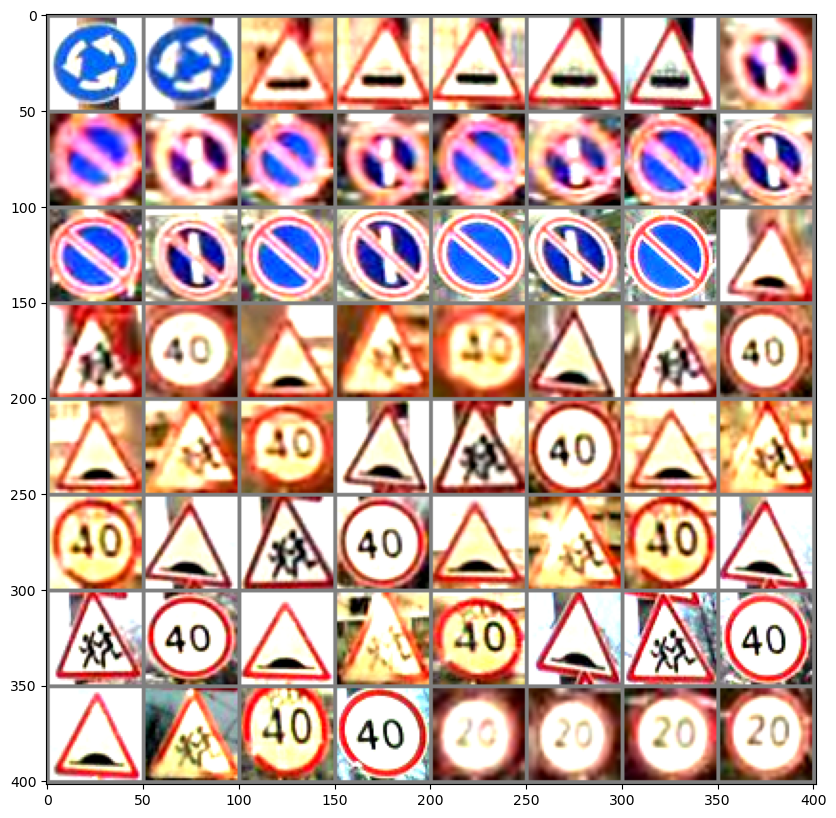

In [79]:
testiter = iter(testloader)
images, impaths = next(testiter)
myshow(torchvision.utils.make_grid(images))

In [77]:
class OurTestDataset(data.Dataset): #отпочковались
  """Our dataset class.

    Arguments:
        root (str): path to images
        imlist - list of file_name
        transform - torchvision transform applied to every image
    """
  def __init__(self, root, flist, transform=None):
        self.root   = root
        self.imlist = flist 
        self.transform = transform

  def __getitem__(self, index):
        #берем строку из пришедшего df по index
        impath = self.imlist[index]

        #собираем полное имя картинки
        full_imname = os.path.join(self.root, impath)

        if not os.path.exists(full_imname): #если нет такой, ругаемся
            print('No file ', full_imname)
            pass

        #Сразу используем PIL тк torchvision.transforms работает с PIL Image (https://pytorch.org/docs/stable/torchvision/transforms.html)
        img = Image.open(full_imname).convert('RGB')

        #применяем к изображению выбранное преобразование (аугментацию)
        img = self.transform(img)

        #на выход отдаём img - нужны для обучения и валидации
        return img, impath

  #метод возвращает длину датасета - просто как длину подаваемого dataframe
  def __len__(self):
        return len(self.imlist)

In [80]:
testset = OurTestDataset(root='./data/test', flist=test_images, transform=transform_for_train_and_val)

batch_size = 64
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, pin_memory=True)

In [81]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [82]:
predictions = {}
for batch_idx, (data, filenames) in enumerate(testloader):
    # Get data to Cuda/MPS
    data = data.to(device=device)
    scores = net(data)

    for filename, score in zip(filenames, scores):
        predictions[filename] = score.argmax().item()
preds_df = pd.DataFrame(predictions.items(), columns=['filename', 'class_number'])
preds_df.to_csv(f'./outputs/predictions_base.csv', index=False)

## **5.3 Сохраняем успехи**

Процесс обучения может идти долго и свалиться в переобучение, обучение просто может упасть почему-нибудь. Чтобы не запускать процесс заново есть смысл сохранять веса (или `checkpoint`) на каждой эпохе/на каждой `N` эпохе/на каждой эпохе пока `loss` падает или метрика качества растет.

Если вы хотите защититься от падения и иметь возможность продолжить обучение с какой то точки, есть смысл сохранять все параметры: `lr`, `state dict` оптимайзера.

In [ ]:
#создаем словать из того что хотим сохранить
state = {
        'epoch': epoch + 1,
        'state_dict': net.state_dict(),
        'optimizer' : optimizer.state_dict()
        }

torch.save(state, './my_checkpoint.pth')

In [ ]:
#проверили что сохранилось
os.path.isfile('./my_checkpoint.pth')

In [ ]:
#заново заведем сеть
net = EasyCNN(n_classes=67)

In [ ]:
net.fc_layers[0].state_dict()

In [ ]:
checkpoint = torch.load('./my_checkpoint.pth')

In [ ]:
checkpoint.keys()

In [ ]:
#к моделе относился только state dict
model_state_dict = checkpoint['state_dict']

In [ ]:
#загрузили
net.load_state_dict(model_state_dict)

In [ ]:
#ура, значения изменились
net.fc_layers[0].state_dict()

In [ ]:
#абсолютно аналогично с оптимайзером
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
optimizer.state_dict()

Чтобы получить лучший результат и больше всего пользы от задания, пересмотрите лекции 2, 3.

А также изучите материалы [тык](https://karpathy.github.io/2019/04/25/recipe/), [тык](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide3/Debugging_PyTorch.html), [тык](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html) и [тык](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html).

Если просто брать модели из `torchvision.models` или писать свои вам уже скучно, попробуйте полазить в [`Model Zoo`](https://github.com/facebookresearch/pycls/blob/main/MODEL_ZOO.md) от `Facebook Research`, там есть всякое интересное.


**На сегодня всё. Успехов с дз :)**